In [2]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import cmasher as cmr
from astropy.io import fits
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()  

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus

In [3]:
def sm(dist, ang_size):
    '''
    takes ang size arsec
    distance pc
    returns diam in pc
    '''
    diam = (ang_size*dist)/206265

    return diam

In [4]:
r_betelgeuse = 29.50*1e-3*u.arcsec


lowcolor = 'steelblue'
highcolor='crimson'

In [73]:
def rp_annulus(data, pix_size_arcsec,position):
    '''
    data, pix size in arcsec, position of center star
    '''
    aperture_size = r_betelgeuse.value / pix_size_arcsec.value #put in pixel units
    aperture = CircularAperture(position,aperture_size)
    photometry = aperture_photometry(data,aperture)
    # print()
    # print("Photometry: ", photometry)

    aperture_sizes = np.arange(1,200,1)
    annuli=[CircularAnnulus(position, r_in=aperture_sizes[i], r_out=aperture_sizes[i+1]) for i in range(len(aperture_sizes)-1)]
    areas = np.array([circle.area for circle in annuli])*pix_size_arcsec**2
    # print(apertures)
    
    
    photometry = aperture_photometry(data, annuli)
    phot_list = []
    for k,v in photometry.items():
        if 'aperture_sum' in k:
            phot_list.append(v)
    phot_array = np.array(phot_list)
    #print(phot_list)
    surf_brightness_jy_arc2 = phot_array.flatten()*u.Jy / (areas)

    centers_arc = ((aperture_sizes[1:]+aperture_sizes[:-1])/2)*pix_size_arcsec
    centers_pc = sm(168,centers_arc).value*u.pc

    centers = {'pc': centers_pc, 'arc': centers_arc}

    return centers,surf_brightness_jy_arc2

reading in data and converting it to different units

In [5]:
# data read in
low_file = "member.uid___A001_X2fb_X200.ari_l.Betelgeuse_sci.spw0_1_2_3_4_338083MHz.12m.cont.I.pbcor.fits"
high_file = "hr_member.uid___A001_X2de_Xf7.ari_l.Betelgeuse_sci.spw0_1_2_3_4_338086MHz.12m.cont.I.pbcor.fits"

In [6]:
hdu_lr = fits.open(low_file, mode= 'update')

In [7]:
data_lr = hdu_lr[0].data
header_lr = hdu_lr[0].header

In [ ]:
theta_lr = header_lr['BPA']
bmaj_lr = header_lr['BMAJ']
bmin_lr = header_lr['BMIN']

In [8]:
hdu_hr = fits.open(high_file, mode= 'update')
data_hr = hdu_hr[0].data
header_hr = hdu_hr[0].header

In [9]:
theta_hr = header_hr['BPA']
bmaj_hr = header_hr['BMAJ']
bmin_hr = header_hr['BMIN']

In [10]:
beam_hr = (header_hr['BMAJ'] * u.deg, header_hr['BMIN']*u.deg)
pix_size_hr = (np.abs(header_hr['CDELT1'])*u.deg,np.abs(header_hr['CDELT2'])*u.deg)
pix_size_arcsec_hr = pix_size_hr[0].to(u.arcsec)
beam_solid_angle_hr = np.pi * beam_hr[0] * beam_hr[1] / (4*np.log(2))

In [11]:
beam_lr = (header_lr['BMAJ'] * u.deg, header_lr['BMIN']*u.deg)
pix_size_lr = (np.abs(header_lr['CDELT1'])*u.deg,np.abs(header_lr['CDELT2'])*u.deg)
pix_size_arcsec_lr = pix_size_lr[0].to(u.arcsec)
beam_solid_angle_lr = np.pi * beam_lr[0] * beam_lr[1] / (4*np.log(2))

In [12]:
beam_solid_angle_arcsec2_lr = beam_solid_angle_lr.to(u.arcsec**2).value # dividing by arcsec conversion to get from beam to arcsec
pixels_per_beam_lr = beam_solid_angle_lr / (pix_size_lr[0]*pix_size_lr[1])

In [13]:
beam_solid_angle_arcsec2_hr = beam_solid_angle_hr.to(u.arcsec**2).value # dividing by arcsec conversion to get from beam to arcsec
pixels_per_beam_hr = beam_solid_angle_hr / (pix_size_hr[0]*pix_size_hr[1])

In [15]:
data_jy_per_pixel_hr = data_hr / pixels_per_beam_hr
data_jy_per_pixel_lr = data_lr / pixels_per_beam_lr

In [16]:
data_jy_per_arcsec2_hr = data_jy_per_pixel_hr / beam_solid_angle_arcsec2_hr
data_jy_per_arcsec2_lr = data_jy_per_pixel_lr / beam_solid_angle_arcsec2_lr

In [67]:
datas = [data_hr,data_jy_per_pixel_hr,data_jy_per_arcsec2_hr,data_lr,data_jy_per_pixel_lr,data_jy_per_arcsec2_lr]
titles= ['hr jy beam', 'hr jy pixel','hr jy arc2','lr jy beam', 'lr jy pixel',  'lr jy arc2']

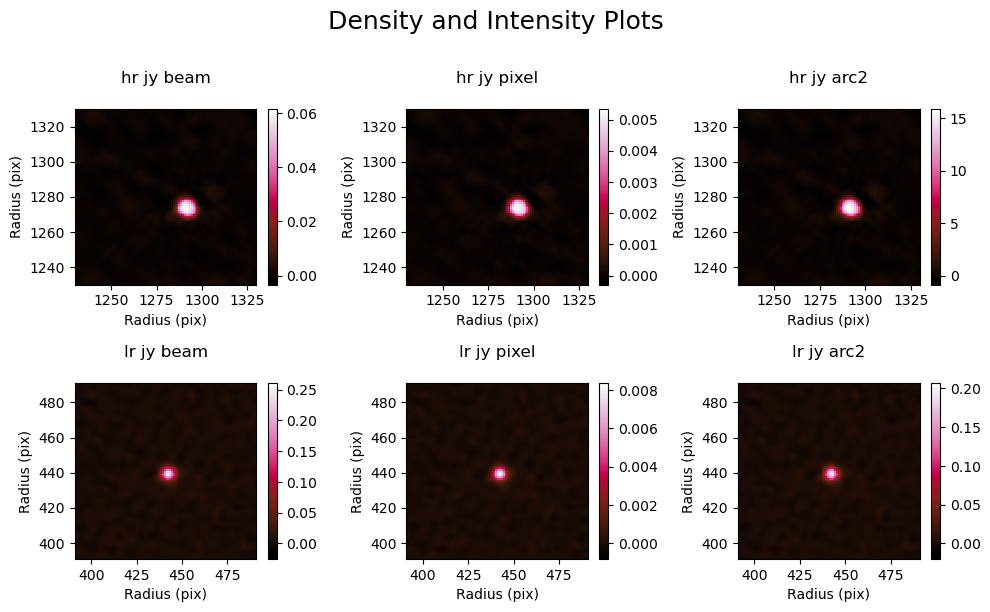

In [68]:
figure,axs = plt.subplots(nrows = 2, ncols=3, figsize = (10,6))#, subplot_kw={'projection': wcs})
figure.suptitle("Density and Intensity Plots", fontsize = 18, y=1.01)


for i,ax in zip(range(len(datas)), axs.ravel()):
     

     im = ax.pcolormesh(datas[i][0,0,...], cmap=cmr.flamingo)

     ax.set_xlim((datas[i].shape[2]/2)-50,(datas[i].shape[2]/2)+50)
     ax.set_ylim((datas[i].shape[3]/2)-50,(datas[i].shape[3]/2)+50)
     ax.set_title(titles[i], y =1.1)
     ax.set_xlabel("Radius (pix)")
     ax.set_ylabel("Radius (pix)")
     figure.colorbar(im,ax=ax)


figure.tight_layout(pad = 1)
plt.show()


our data has now been converted from jy/beam to jy/pixel and jy/arc2

now find brightest pixels. 

### we can manually pick the positions to correct for convection, but I am not adding that yet. This is normally where it would go

In [71]:
for i in range(len(datas)):
    max_pos = np.unravel_index(np.argmax(np.ma.masked_invalid(datas[i])), datas[i].shape)
    print(max_pos)
    y = max_pos[-1]
    x = max_pos[-2]

(0, 0, 1273, 1290)
(0, 0, 1273, 1290)
(0, 0, 1273, 1290)
(0, 0, 439, 442)
(0, 0, 439, 442)
(0, 0, 439, 442)


In [76]:
position_hr=(1273,1290)
position_lr=(439,442)

getting the radial profiles around the centers

In [79]:
centers_hr=[None]*3
rp_hr=[None]*3

for i in range(3):
    centers_hr[i], rp_hr[i] = rp_annulus(datas[i][0,0,...],pix_size_hr[0].to(u.arcsec),position_hr)
    print(titles[i])

hr jy beam
hr jy pixel
hr jy arc2


In [81]:
centers_lr=[None]*3
rp_lr=[None]*3

for i in range(3):
    centers_lr[i], rp_lr[i] = rp_annulus(datas[i+3][0,0,...],pix_size_lr[0].to(u.arcsec),position_lr)
    print(titles[i+3])

lr jy beam
lr jy pixel
lr jy arc2
